In [33]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from imageio import imread
from skimage.transform import resize
from scipy.spatial import distance
from keras.models import load_model
import heapq

%matplotlib inline

In [2]:
cascade_path = '../model/cv2/haarcascade_frontalface_alt2.xml'

In [3]:
image_dir_basepath = '../data/images/'
names = [r for r in range(1,2000)]
image_size = 160

In [4]:
model_path = '../model/keras/model/facenet_keras.h5'
model = load_model(model_path)

/Users/lovelycute/anaconda3/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:
def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y

def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

In [88]:
def load_and_align_images(filepaths, margin):
    cascade = cv2.CascadeClassifier(cascade_path)
    
    aligned_images = []
    for filepath in filepaths:
#         print(filepath)
        img = imread(filepath)
        try:
            xxoo=img.shape[2]
        except:
            img=img[:,:, np.newaxis]
            img = np.dstack((np.dstack((img,img)),img))
        
        faces = cascade.detectMultiScale(img,
                                         scaleFactor=1.1,
                                         minNeighbors=1)
#         print(img.shape)
#         print(faces[0])
        (x, y, w, h)=[46,42,163,163]
        # (x, y, w, h) = faces[0]
        cropped = img[y-margin//2:y+h+margin//2,
                      x-margin//2:x+w+margin//2, :]
        aligned = resize(cropped, (image_size, image_size), mode='reflect')
        aligned_images.append(aligned)
    return np.array(aligned_images)

In [7]:
def calc_embs(filepaths, margin=10, batch_size=1):
    # print(filepaths)
    aligned_images = prewhiten(load_and_align_images(filepaths, margin))
    pd = []
    for start in range(0, len(aligned_images), batch_size):
        pd.append(model.predict_on_batch(aligned_images[start:start+batch_size]))
    embs = l2_normalize(np.concatenate(pd))

    return embs

In [8]:
def calc_dist(img_name0, img_name1):
    return distance.euclidean(data[img_name0]['emb'], data[img_name1]['emb'])

def calc_dist_plot(img_name0, img_name1):
    print(calc_dist(img_name0, img_name1))
    plt.subplot(1, 2, 1)
    plt.imshow(imread(data[img_name0]['image_filepath']))
    plt.subplot(1, 2, 2)
    plt.imshow(imread(data[img_name1]['image_filepath']))

In [89]:
data = {}
for name in names:
    image_dirpath = '../700103144_1_HW_1_Face/HW_1_Face/' + str(name)
#     image_dirpath = image_dir_basepath + name
#     image_filepaths = [os.path.join(image_dirpath, f) for f in os.listdir(image_dirpath)]
    image_filepaths = [image_dirpath+f for f in ['_1.jpg','_2.jpg']]
    embs = calc_embs(image_filepaths)
    for i in range(len(image_filepaths)):
        data['{}{}'.format(name, i)] = {'image_filepath' : image_filepaths[i],
                                        'emb' : embs[i]}

1.3280696868896484


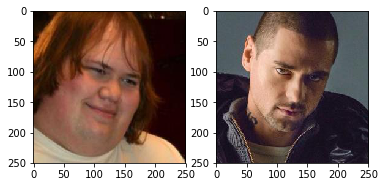

In [90]:
calc_dist_plot('10', '21')

# calculate the accuracy

In [91]:
def accuracy(topk,data):
    acc=0
    topk+=1
    for i in range(1,2000):
        score=[]
        for j in range(1,2000):
            if(i==j):
                continue
            score.append((-calc_dist(str(i)+'1',str(j)+'0')))
        if (i in heapq.nlargest(topk, range(len(score)), score.__getitem__)):
            acc+=1
            print('acc:',str(acc/1999))
    print('acc:',str(acc/1999))

In [92]:
accuracy(5,data)

acc: 0.0005002501250625312
acc: 0.0010005002501250625
acc: 0.0015007503751875938
acc: 0.002001000500250125
acc: 0.0025012506253126563
acc: 0.0030015007503751876
acc: 0.003501750875437719
acc: 0.00400200100050025
acc: 0.004502251125562781
acc: 0.004502251125562781


In [93]:
accuracy(1,data)

acc: 0.0005002501250625312
acc: 0.0010005002501250625
acc: 0.0015007503751875938
acc: 0.0015007503751875938
